The human cell atlas project is growing and I want to know how to use it. 

[The Human Lung Cell Atlas (HLCA)](https://www.nature.com/articles/s41591-023-02327-2) was published in 2023. It has ~2.3 Million cells and can be downloaded here: [data.humancellatlas.org/hca-bio-networks/lung/atlases/lung-v1-0](https://data.humancellatlas.org/hca-bio-networks/lung/atlases/lung-v1-0)

In this notebook I will download the atlas and explore the data that is provided. For me this is a way to learn about a new resource I am not yet familiar with, but would like to understand better. I love that the resource is freely accessible and hope I can make use of it in the future. 

## Downloading the HLCA

Downloading is very easy but as the file is 20 GB, a bit of storage space is required:

```sh
wget https://datasets.cellxgene.cziscience.com/8d84ba15-d367-4dce-979c-85da70b868a2.h5ad
```

Now that the data is there I need to open it. For that I will set up a new mamba environment:

```sh
mamba create -n HLCA python==3.11 uv==0.3.3
mamba activate HLCA
uv pip install plotnine==0.13.6 scanpy==1.10.2 
```

With that sorted I can get started.

## Loading the Data

To handle the dataset I will be using [scanpy](https://scanpy.readthedocs.io/en/stable/), a python package for Single-Cell analysis. As the dataset is very large and my machine only has 32GB of RAM, I will have to work around that. To get started I load the file in `backed` mode, which does not load the entire file into memory:

In [1]:
import scanpy as sc

hlca = sc.read_h5ad("./data/HLCA/8d84ba15-d367-4dce-979c-85da70b868a2.h5ad", backed='r')
print(hlca)

AnnData object with n_obs × n_vars = 2282447 × 56239 backed at 'data/HLCA/8d84ba15-d367-4dce-979c-85da70b868a2.h5ad'
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_

There is a lot of metadata and other data here. After a bit of reading I found out that the count matrix data is located in the `.raw.X` attribute  while transformed values are in `.X`.

In [2]:
hlca.X.shape

(2282447, 56239)

I know from the web portal that the dataset contains 2.3 Million cells, meaning the dataset contains exactly 2282447 cells with 56239 different transcript columns.

I love seeing the raw data, to get a feel for it:

In [3]:
hlca.X[:10, :10].todense()

matrix([[0.       , 0.       , 0.       , 0.6809068, 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 1.6584647, 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 3.2713356, 0.       ,
         0.       , 1.4275113, 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.       , 0.       ,
         0.       , 0.       , 0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       , 2.7450175, 0.       ,
         0.       , 0.       , 0.

To work with the data I will need access to the transcript names, those are store in the `var_names` attribute:

In [4]:
hlca.var_names

Index(['ENSG00000121410', 'ENSG00000268895', 'ENSG00000148584',
       'ENSG00000175899', 'ENSG00000245105', 'ENSG00000166535',
       'ENSG00000256661', 'ENSG00000256904', 'ENSG00000256069',
       'ENSG00000184389',
       ...
       'ENSG00000135679', 'ENSG00000169760', 'ENSG00000100889',
       'ENSG00000008710', 'ENSG00000164088', 'ENSG00000174903',
       'ENSG00000159167', 'ENSG00000136854', 'ENSG00000135605',
       'ENSG00000109501'],
      dtype='object', length=56239)

So now I have loaded the data and I have full access to both the raw and the log-transformed counts. Next I want to dive further into the metadata.

## Plotting UMAPs

I would love to see the data as a UMAP. The authors actually included a UMAP representation of the data, which lets me avoid computing the UMAP locally.

I am going to use plotnine here instead of using the integrated plotting functions, because I want to have more control. But the [plotting](https://scanpy.readthedocs.io/en/stable/api/plotting.html) functions of scanpy are very nice to have.

To get started and be able to work with this large dataset on my computer, I will subsample randomly to a more convenient size for my personal computer:

In [5]:
import pandas as pd

# Randomly sample from the cells, to make exploration a bit easier
n = 10000
index = range(len(hlca.obsm["X_umap"]))
cell_index = pd.Series(index).sample(n=n, random_state=1).values
hlca_small = hlca[cell_index, :].to_memory()

With this smaller dataset I won't be able to perform robust analysis, at least I am losing a lot of statistical power, but for exploring the dataset and the options scanpy offers this is much easier. 


As mentioned before, the dataset already contains a batch corrected low dimensionality embedding of all cells. This can be accessed using the `X_umap` key. 

If you want to interactively explore this data yourself you can also checkout [cellxgene.cziscience.com/e/9f222629-9e39-47d0-b83f-e08d610c7479.cxg](https://cellxgene.cziscience.com/e/9f222629-9e39-47d0-b83f-e08d610c7479.cxg/), where you can see the entire dataset.

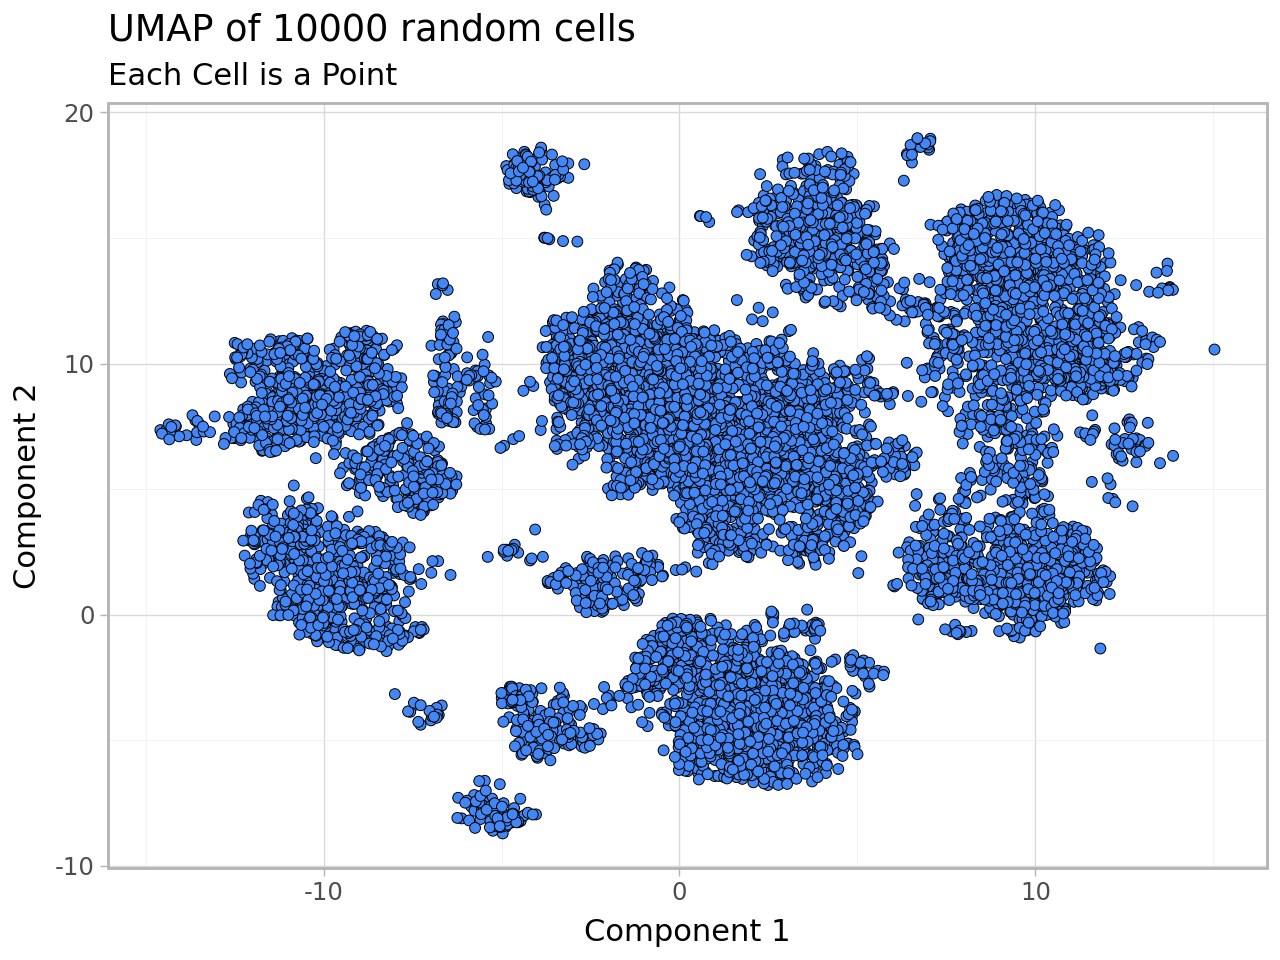

In [6]:
import plotnine as p9
df= pd.DataFrame(hlca_small.obsm["X_umap"])
df.columns = ["UMAP1", "UMAP2"]
(
        p9.ggplot(df, p9.aes(x="UMAP1", y="UMAP2"))
        + p9.geom_point(size=2, stroke=0.2, fill="#4287f5")
    
        + p9.labs(
            title=f"UMAP of {len(df)} random cells",
            subtitle="Each Cell is a Point",
            x="Component 1",
            y="Component 2",
        )
        + p9.theme_light()
    )



I am curious about some of the annotations. So I will color the plot by some of the metadata provided. These are the features to choose from:

In [7]:
", ".join(hlca_small.obs.columns.to_list())

"suspension_type, donor_id, is_primary_data, assay_ontology_term_id, cell_type_ontology_term_id, development_stage_ontology_term_id, disease_ontology_term_id, self_reported_ethnicity_ontology_term_id, tissue_ontology_term_id, organism_ontology_term_id, sex_ontology_term_id, 3'_or_5', BMI, age_or_mean_of_age_range, age_range, anatomical_region_ccf_score, ann_coarse_for_GWAS_and_modeling, ann_finest_level, ann_level_1, ann_level_2, ann_level_3, ann_level_4, ann_level_5, cause_of_death, core_or_extension, dataset, fresh_or_frozen, log10_total_counts, lung_condition, mixed_ancestry, original_ann_level_1, original_ann_level_2, original_ann_level_3, original_ann_level_4, original_ann_level_5, original_ann_nonharmonized, reannotation_type, sample, scanvi_label, sequencing_platform, smoking_status, study, subject_type, tissue_coarse_unharmonized, tissue_detailed_unharmonized, tissue_dissociation_protocol, tissue_level_2, tissue_level_3, tissue_sampling_method, total_counts, transf_ann_level_1_

That is quite a lot of features, I first make a plotting function that allows me to color by a feature:

In [8]:
def plot_metadata(df: pd.DataFrame, feature: list, feature_name: str, width: int = 6):
    df["feature"] = feature
    return (
        p9.ggplot(df, p9.aes(x="UMAP1", y="UMAP2", fill = "feature"))
        + p9.geom_point(size=2, stroke=0.2)
    
        + p9.labs(
            title=f"UMAP of {len(df)} random cells",
            subtitle=f"Each Cell is a Point, colored by {feature_name}",
            x="Component 1",
            y="Component 2",
            fill=feature_name
        )
        + p9.theme_light() +
        p9.theme(
         figure_size=(width, 5)
        )
    )


Now I can plot for example the Sequencing Platform data:

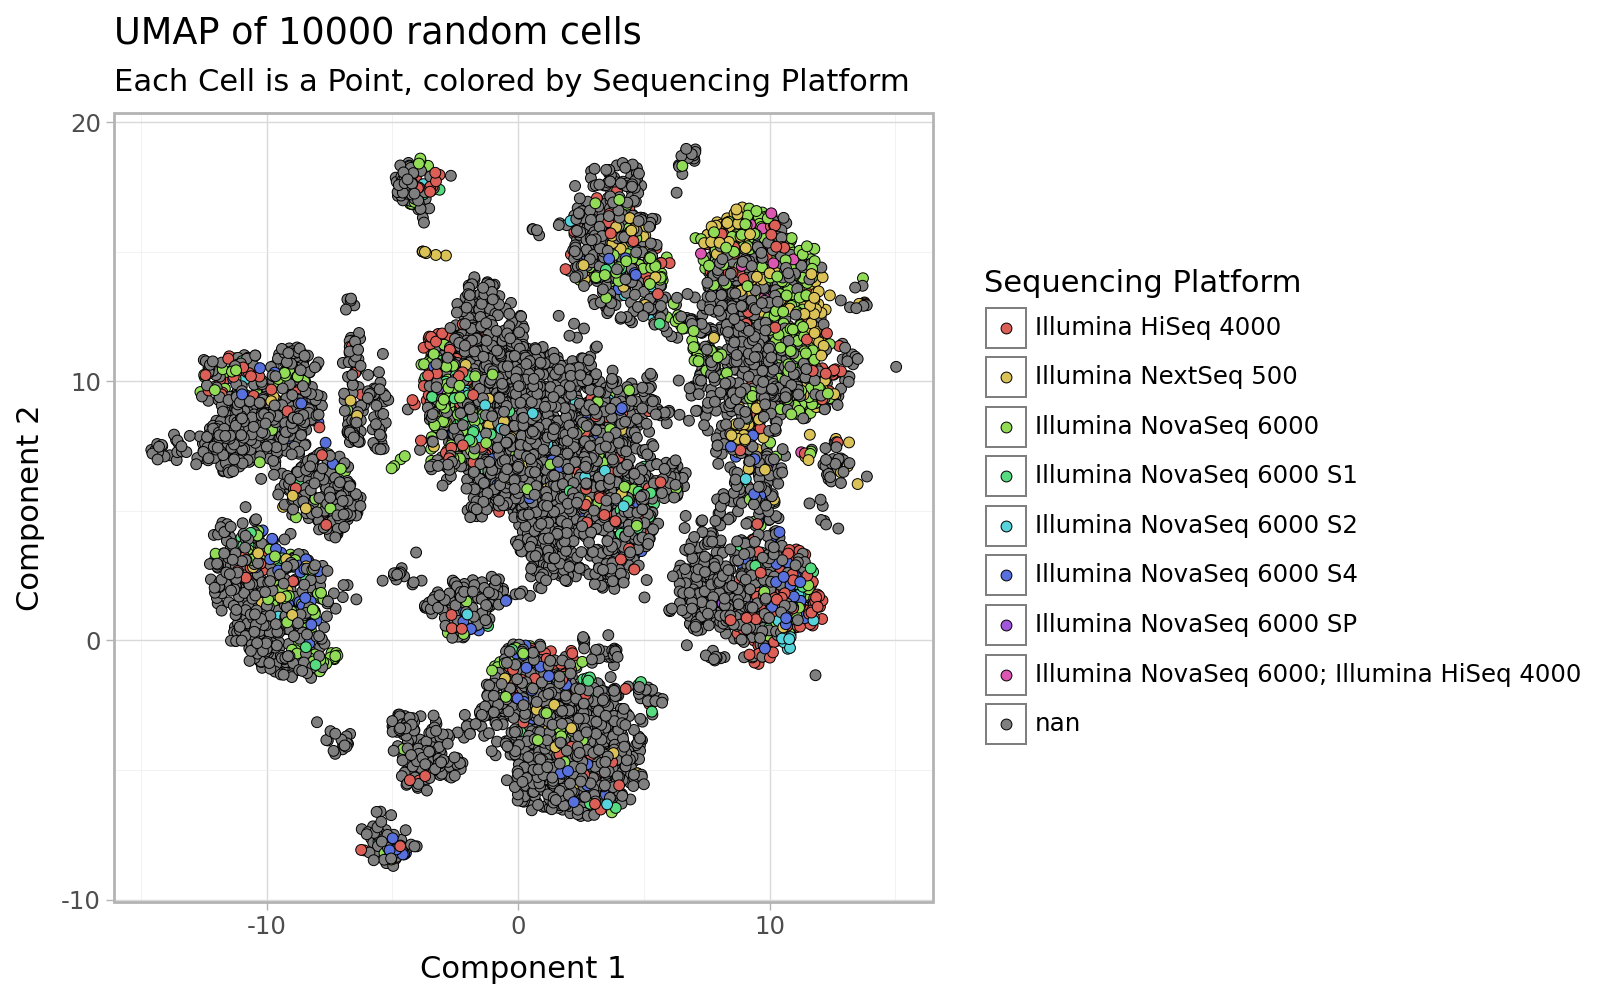

In [9]:
feature  = hlca_small.obs.sequencing_platform.values.tolist()
plot_metadata(df, feature, "Sequencing Platform", width = 8)

Or the Study from which the data was sourced:

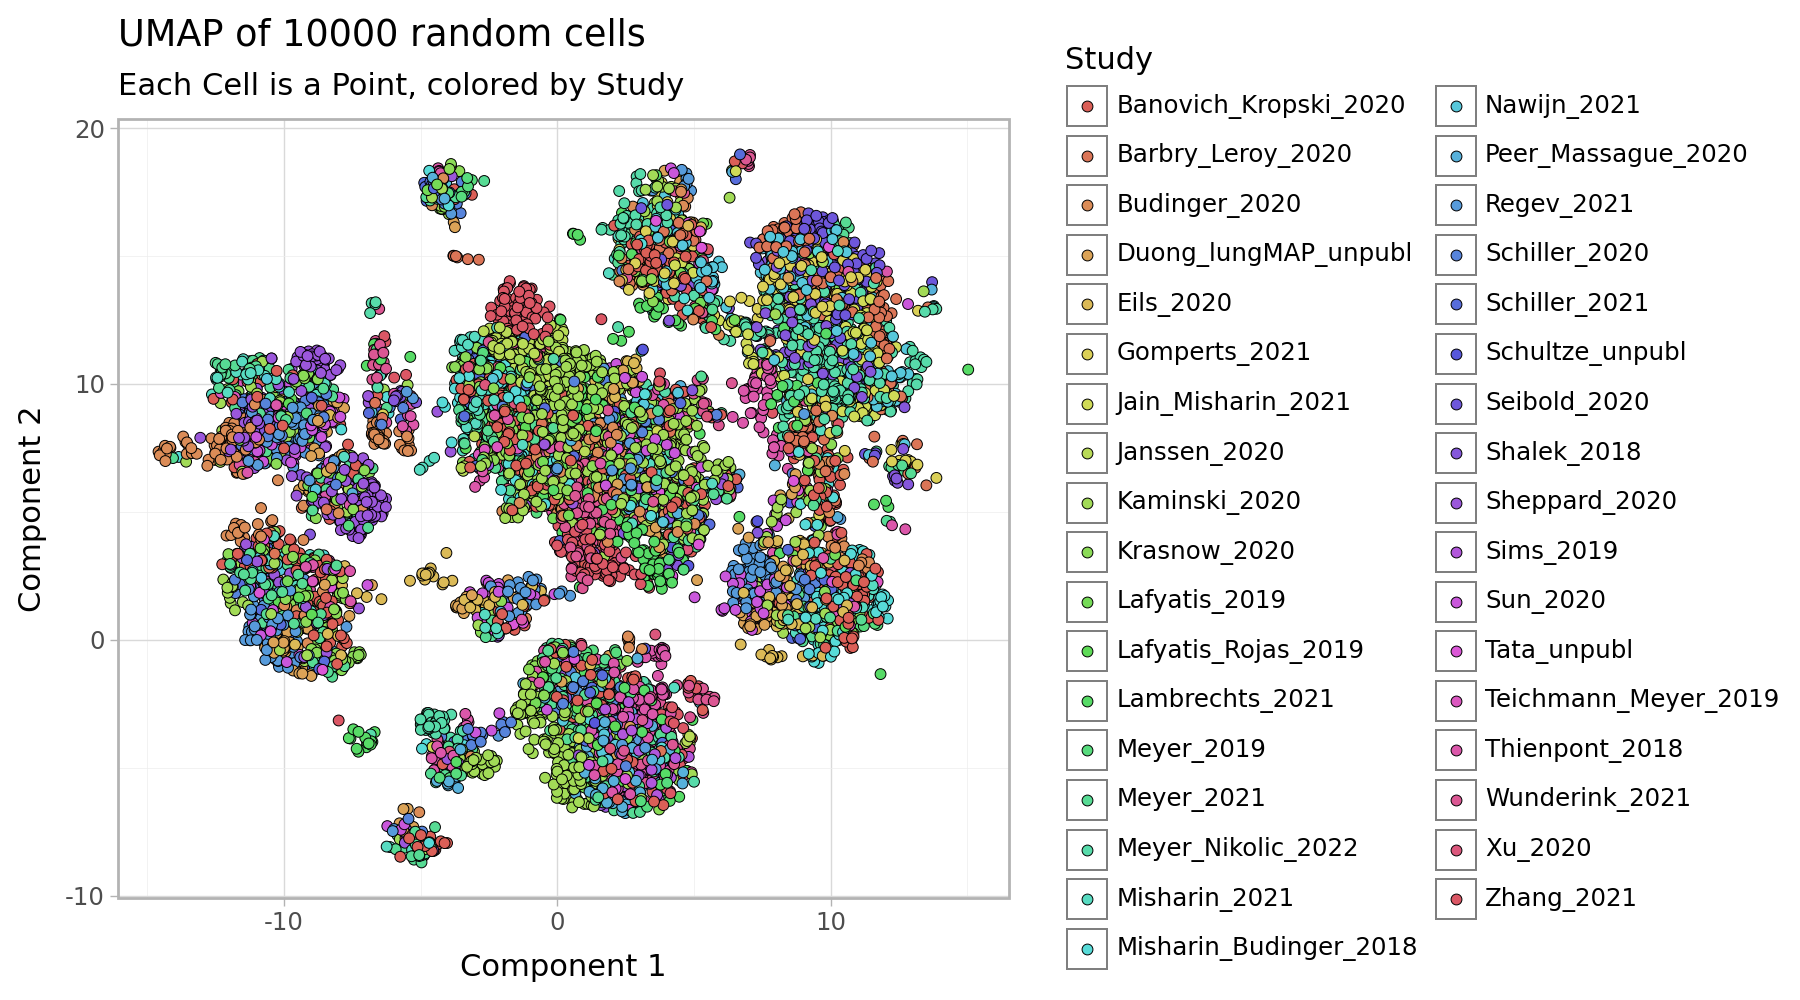

In [10]:
feature  = hlca_small.obs.study.values.tolist()
plot_metadata(df, feature, "Study", width = 9)

Or the `Smoking Status`:

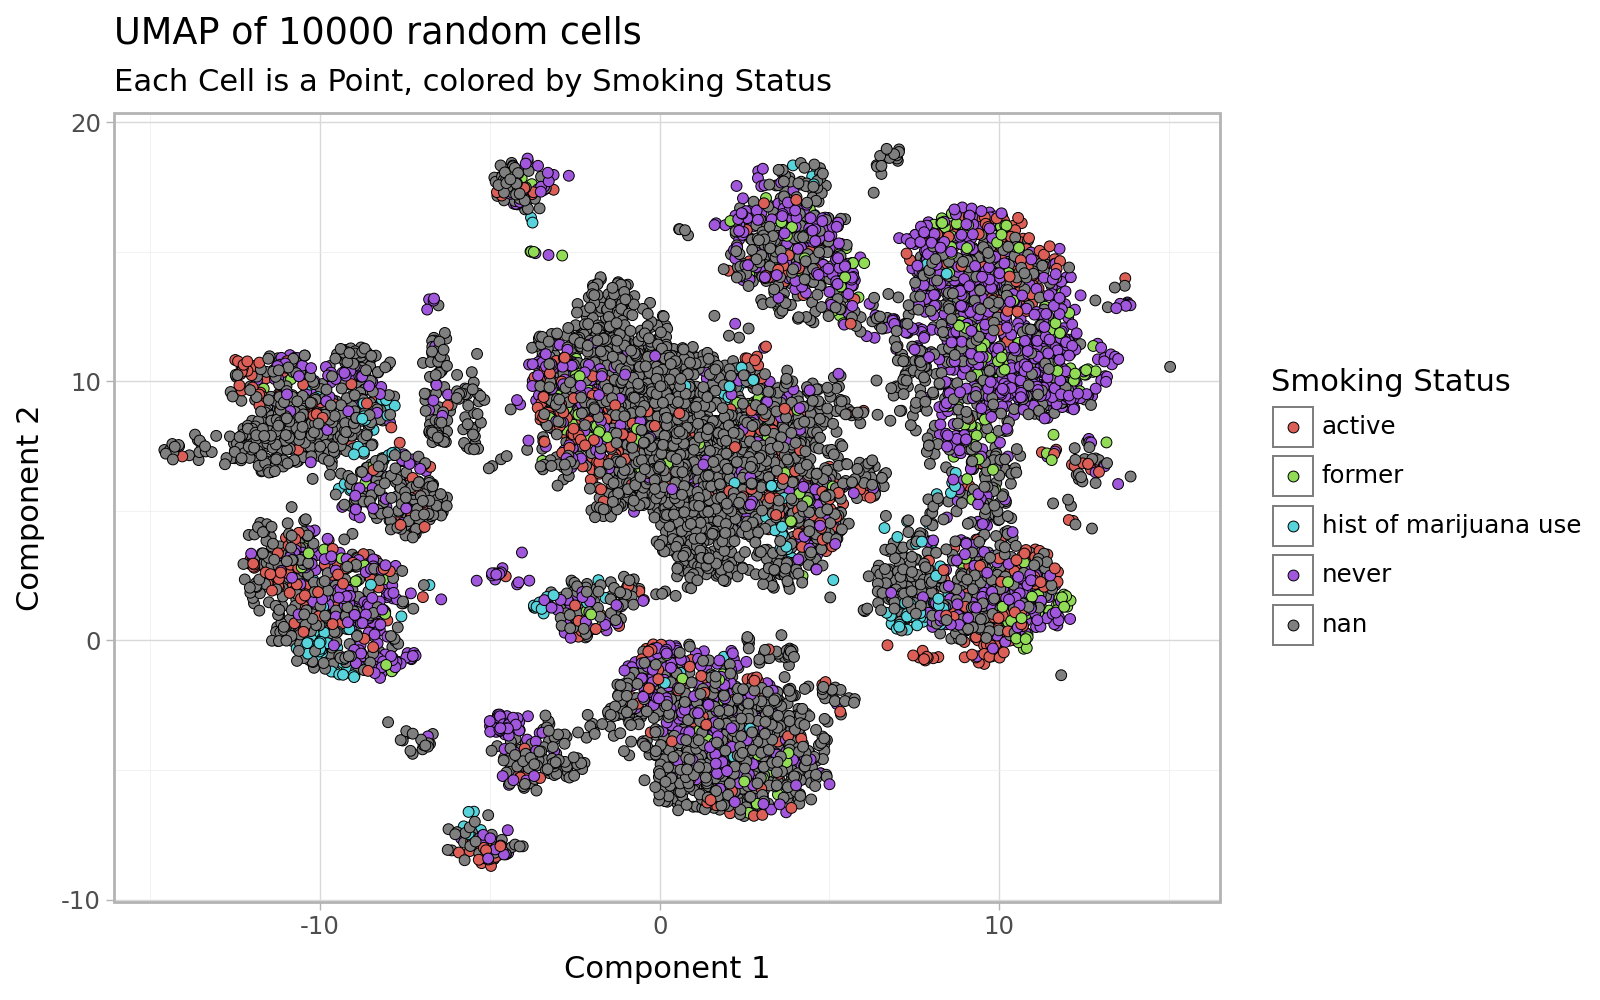

In [11]:
feature  = hlca_small.obs.smoking_status.values.tolist()
plot_metadata(df, feature, "Smoking Status", width = 8)

Or the tissue:

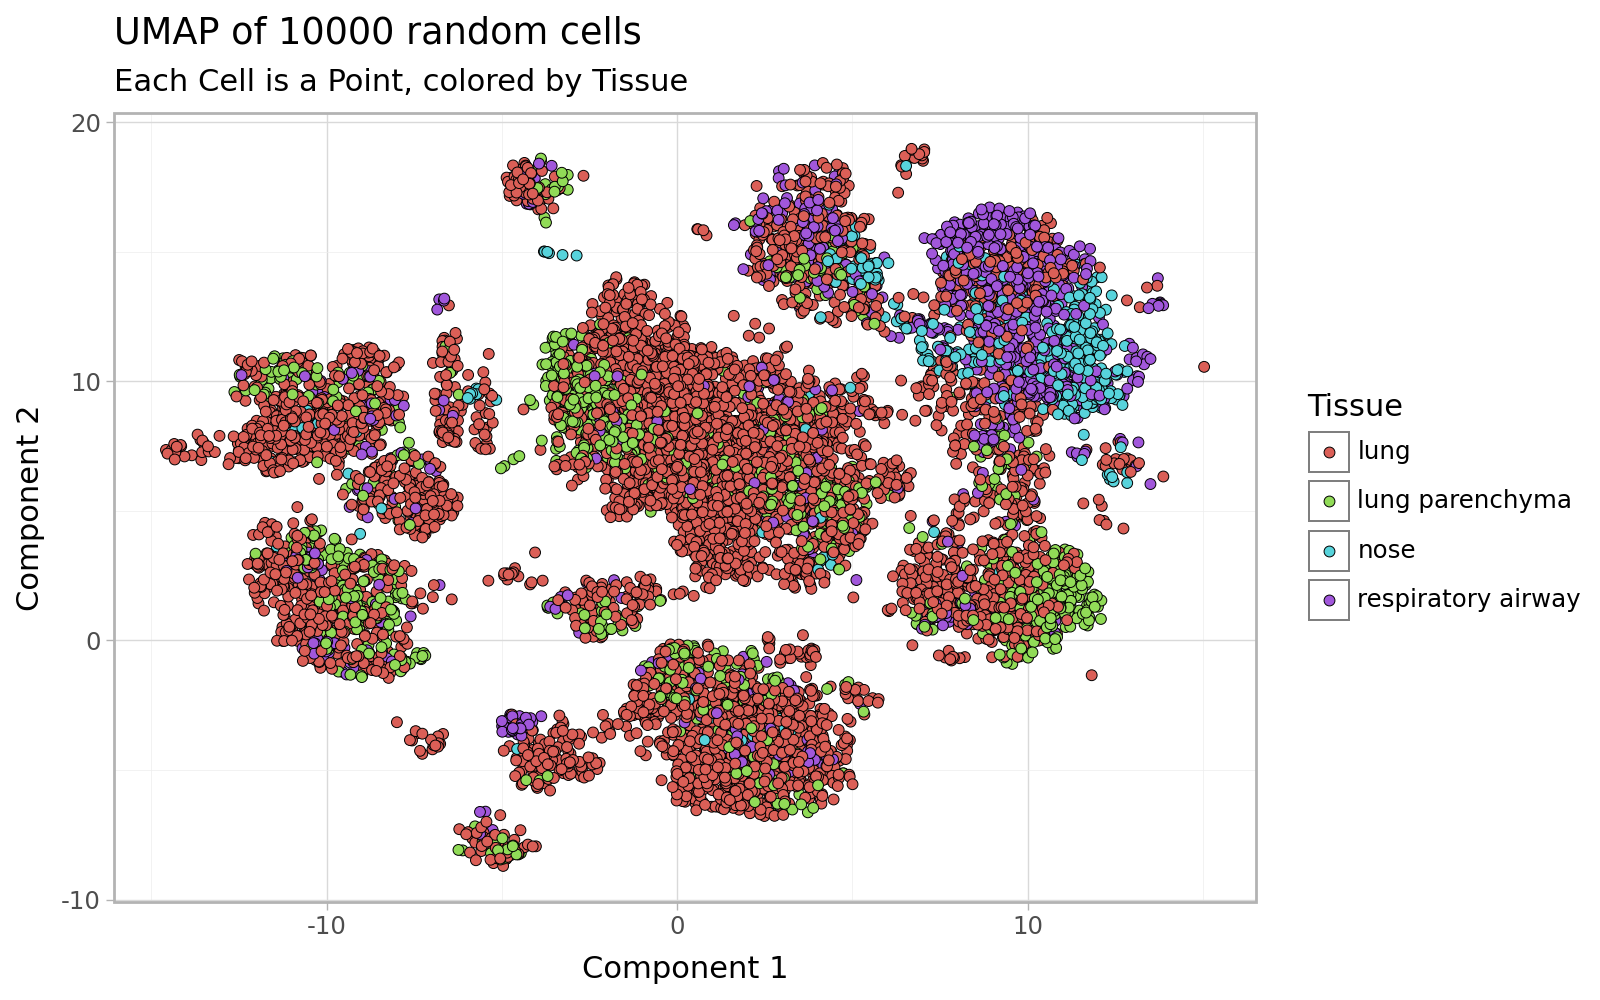

In [12]:
feature  = hlca_small.obs.tissue.values.tolist()
plot_metadata(df, feature, "Tissue", width = 8)

That is pretty interesting to look at and I could spend hours now looking at each feature. A few features I still need to understand. I see in the feature table each 5 labels for:

- original_ann_level_1
- ann_level_1
- transf_ann_level_1_label
- transf_ann_level_1_uncert

These seem to be annotation levels. I would like to understand where they come from. For that I am turning to the paper.

The core HLCA annotations were transferred (`transf`) to the extended atlas using ''scArches k nearest neighbor-based label transfer algorithm''. This explains where the transfer labels come from. 

The columns `_uncert` should contain the 'uncertainty score' associated with that label transfer.   

If I understand correctly, the `original_ann_level_1`  to contain labels annotated manually while the `ann_level_1` contains the inferred labels. 




In [13]:
print(hlca_small.obs[["original_ann_level_1", "ann_level_1", "transf_ann_level_1_label", "transf_ann_level_1_uncert"]].head().to_markdown())

|                                                           | original_ann_level_1   | ann_level_1   | transf_ann_level_1_label   |   transf_ann_level_1_uncert |
|:----------------------------------------------------------|:-----------------------|:--------------|:---------------------------|----------------------------:|
| AATGAAGCATTCTTCA-17_bharat                                | nan                    | Immune        | Immune                     |                           0 |
| GTTGCGGAGGCATCTT-16_bharat                                | nan                    | Immune        | Immune                     |                           0 |
| GGAGCAAAGCAGATCG-CV001_KM8854608-ucl_meyer_nikolic_unpubl | nan                    | Epithelial    | Epithelial                 |                           0 |
| CCGTGGACAGCCAGAA-1-HCATisStab7747197                      | Endothelial            | Endothelial   | nan                        |                         nan |
| 7185212_TTTGGTTGTCCGTCAG  

Now I can color the UMAP by the annotations:

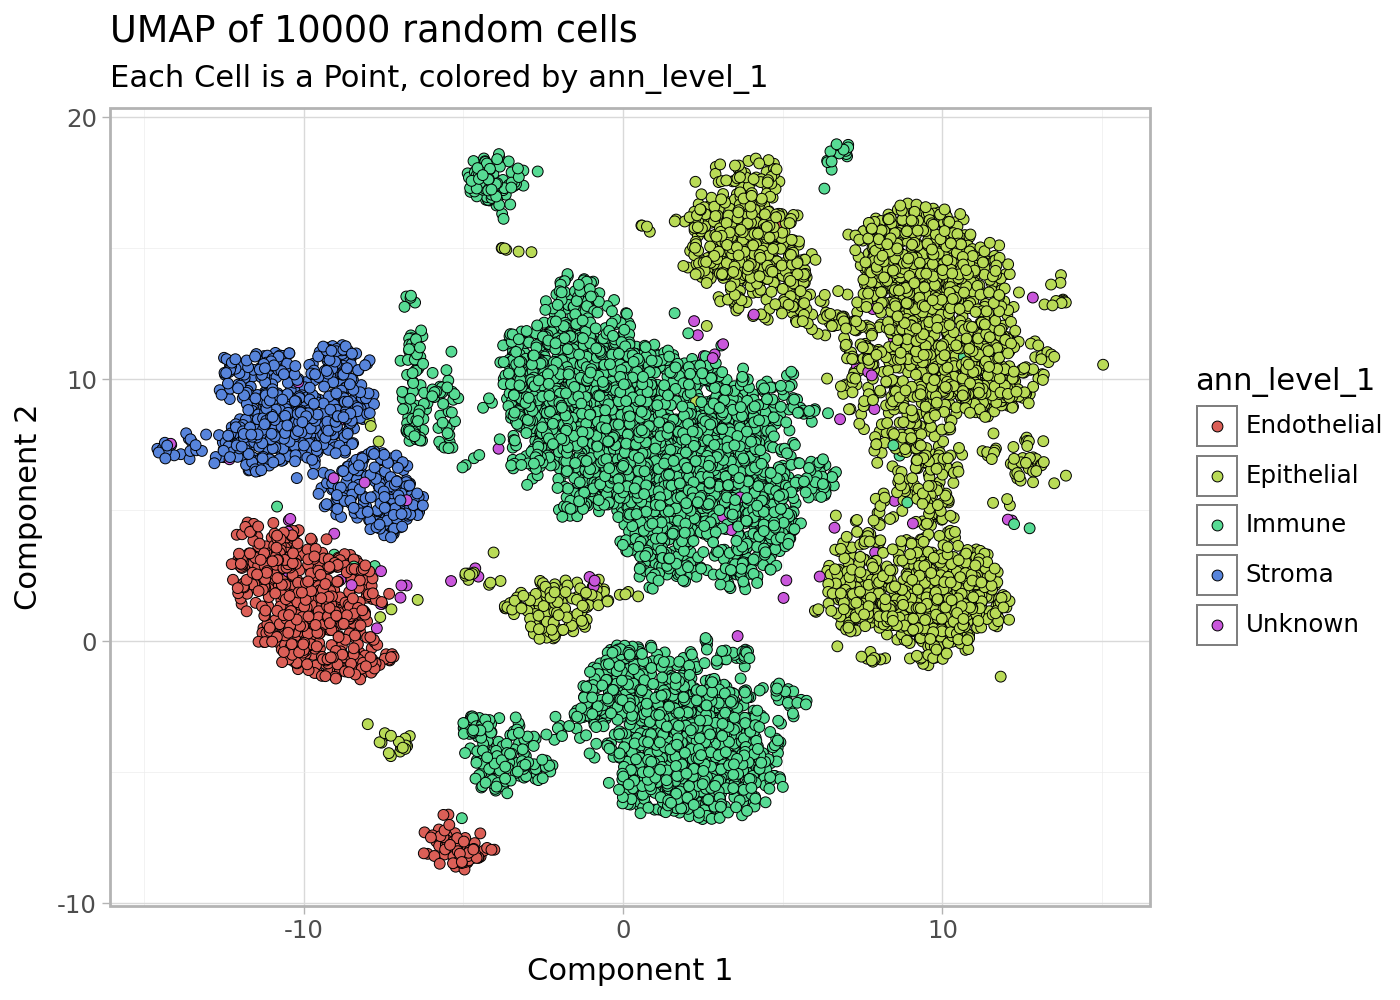

In [14]:
feature  = hlca_small.obs.ann_level_1.values.tolist()
plot_metadata(df, feature, "ann_level_1", width = 7)

So I think I understand those annotation columns correctly.  And I can go ever deeper into the tissue/cell types:

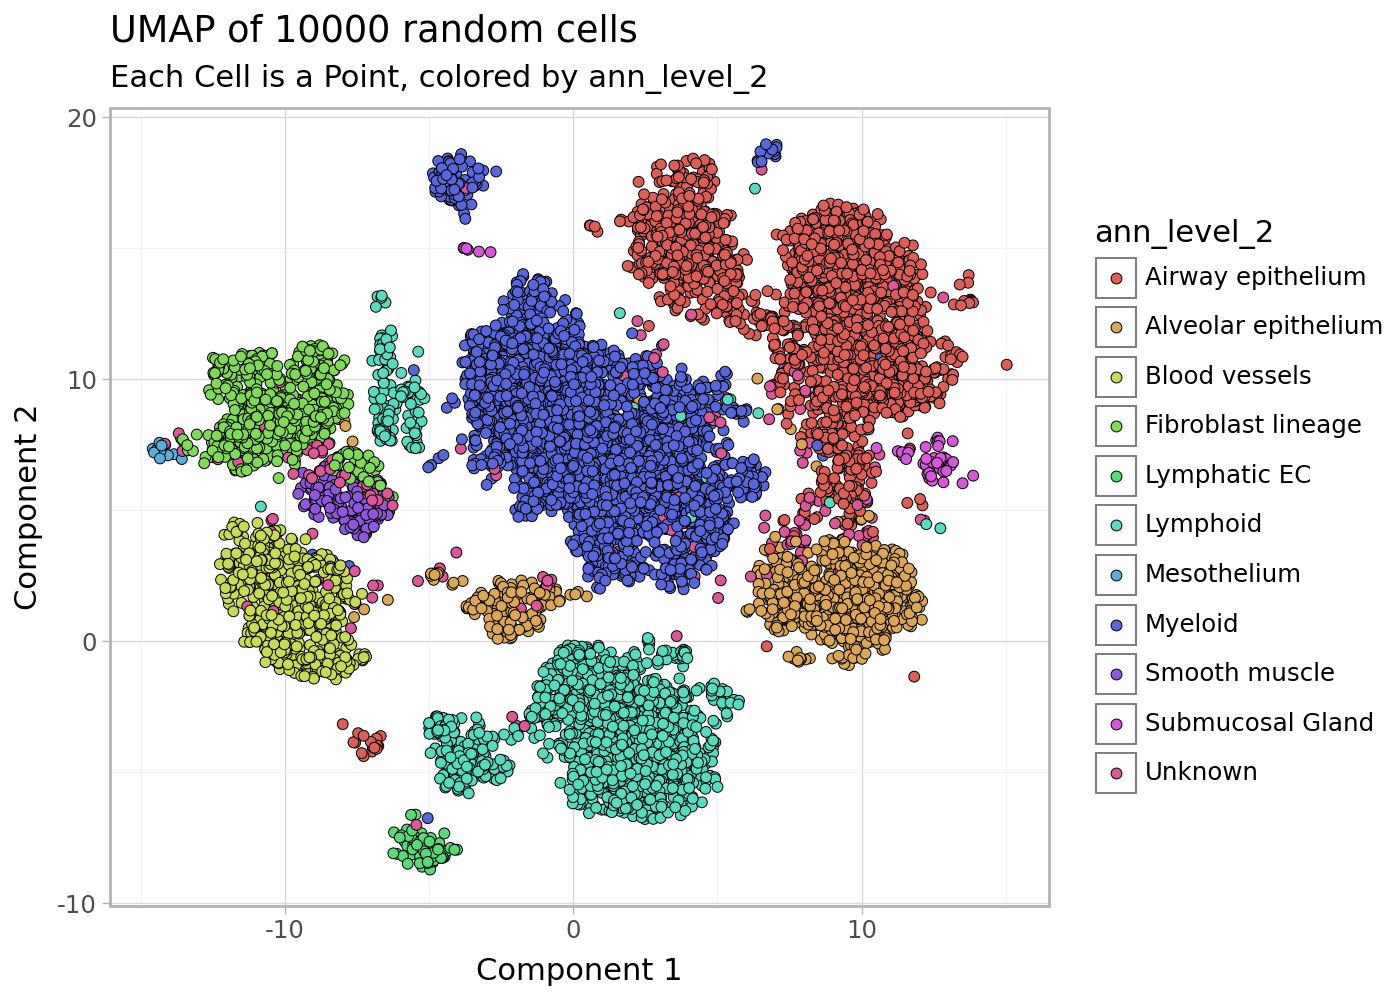

In [15]:
feature  = hlca_small.obs.ann_level_2.values.tolist()
plot_metadata(df, feature, "ann_level_2", width = 7)

So that is the metadata. But indeed, one might be more interested in certain genes. So of course one can also color the UMAP by a gene ID. Lets say I want to color by the expression of **ACTB** ([ENSG00000075624](https://www.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000075624;r=7:5526409-5563902)):

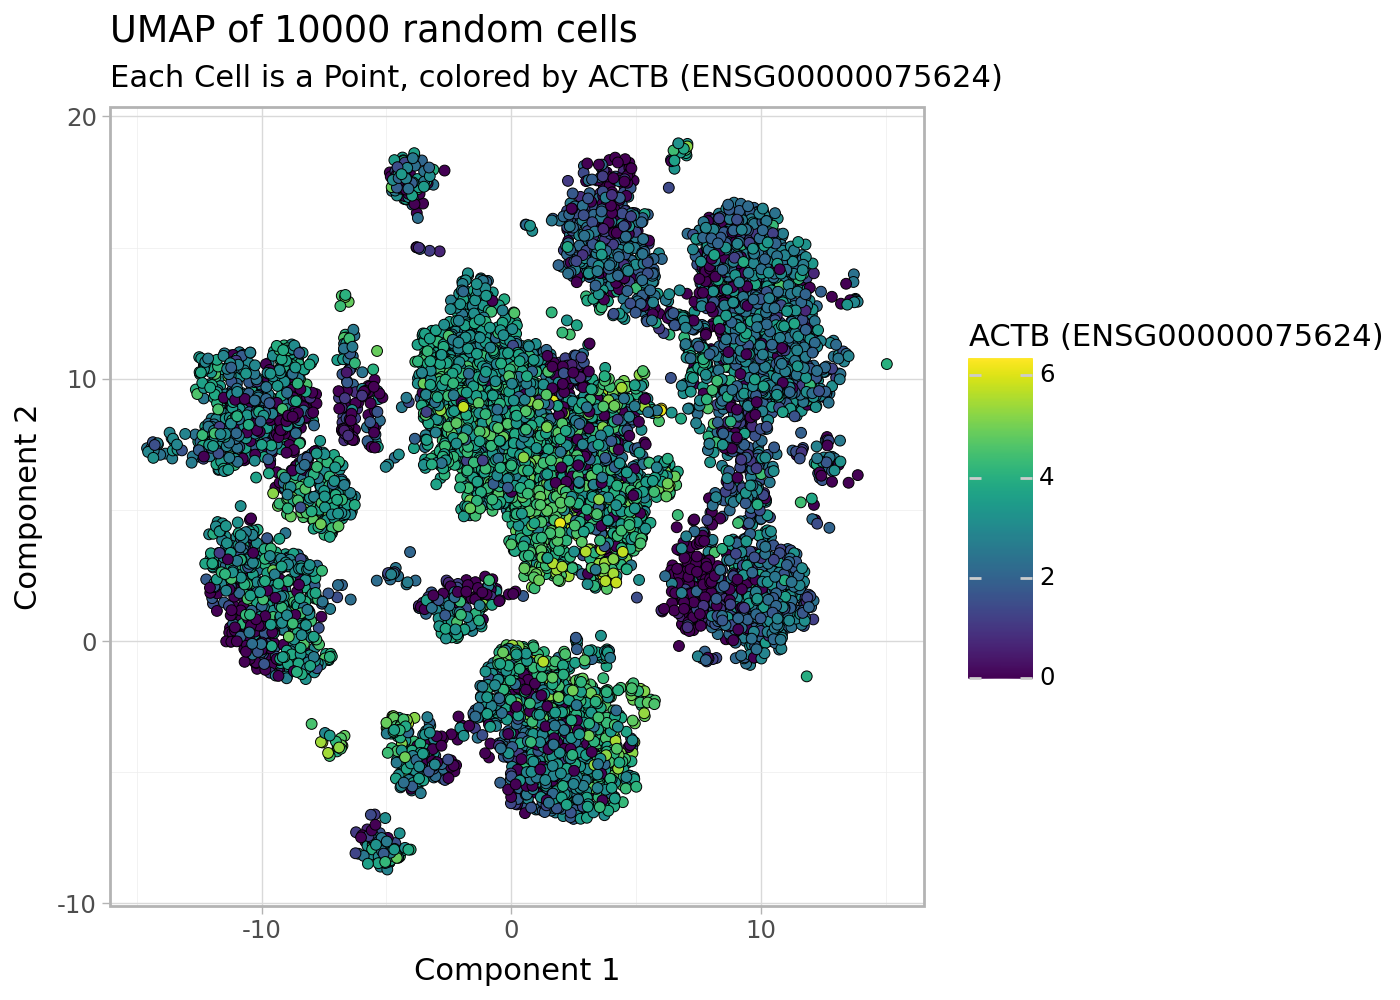

In [16]:
column_idx = hlca_small.var_names.to_list().index("ENSG00000075624")
feature = hlca_small.X[:,column_idx].toarray().flatten()
plot_metadata(df, feature, "ACTB (ENSG00000075624)", width = 7)

Important to note that the docs mention that the raw counts are not batch corrected ([data.humancellatlas.org/hca-bio-networks/lung/atlases/lung-v1-0](https://data.humancellatlas.org/hca-bio-networks/lung/atlases/lung-v1-0)). To correct for batch effects would be too big of a computation though for my small computer. So I have to move forward without it for the sake of exploring this dataset.

## Differential Gene Expression Analysis

No RNA-seq analysis is complete without a bit of differential gene expression analysis. I thought the easiest would be to focus on healthy samples and have a look at different groups of cells.

First I have to decide on a annotation level and subset to healthy cells:

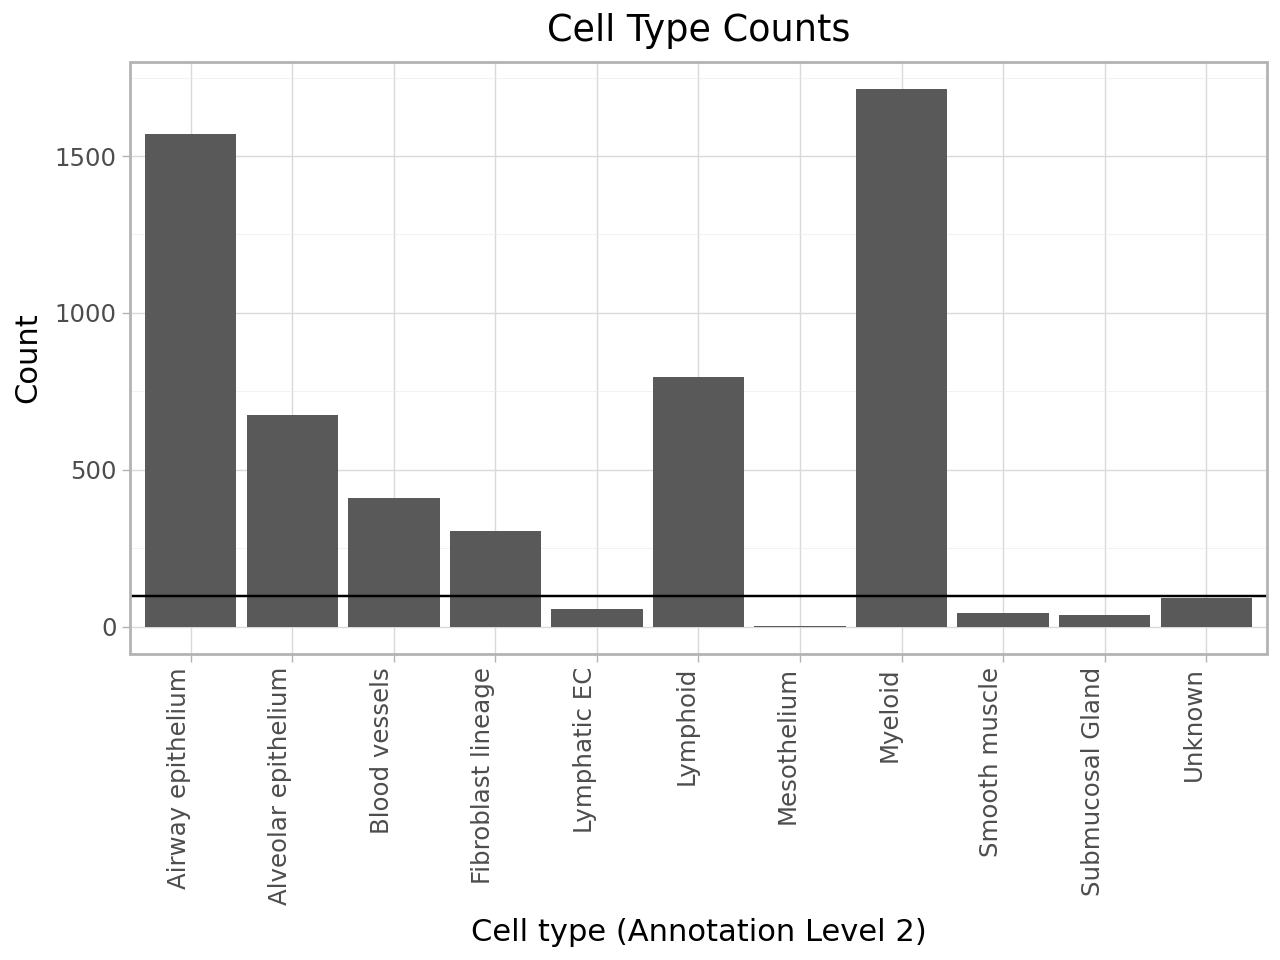

In [17]:
import pandas as pd
import plotnine as p9

df = hlca_small.obs.copy()

# Create a new DataFrame with the tissue and disease columns
df = df[df.disease.isin(["normal"])].reset_index()
(
    p9.ggplot(df, p9.aes(x='ann_level_2')) +
    p9.geom_bar(position='dodge') +
    p9.theme_light() +
    p9.labs(title='Cell Type Counts',
            x='Cell type (Annotation Level 2)',
            y='Count',
            fill = "Disease") +
    p9.geom_hline(yintercept = 100) + 
    p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1))
) 

I remove small groups and set a threshold of 100 cells:

In [18]:
cell_counts = df['ann_level_2'].value_counts()
valid_ann_levels = cell_counts[cell_counts >= 100].index

hlca_small_filtered = hlca_small[(hlca_small.obs['ann_level_2'].isin(valid_ann_levels)) & (hlca_small.obs['disease'].isin(["normal"]))]

Now I use scanpy to do a differential gene expression analysis between these classes:

/home/paul/mambaforge/envs/reproduce_hic/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/paul/mambaforge/envs/reproduce_hic/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 56239 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.


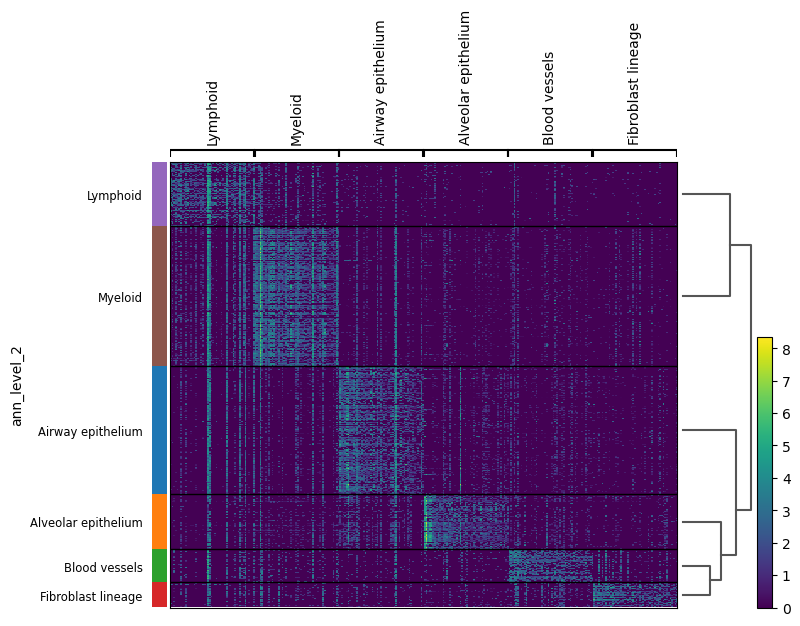

In [19]:
sc.tl.rank_genes_groups(hlca_small_filtered, groupby='ann_level_2', method='t-test', use_raw = False)
sc.tl.dendrogram(hlca_small_filtered, groupby=["ann_level_2"])
sc.pl.rank_genes_groups_heatmap(hlca_small_filtered, n_genes = 50,  use_raw=False, show_gene_labels=False, figsize=(8, 6))

Thats a heatmap showing the top 50 differentially expressed genes across 6 annotated classes. Very cool how easy scanpy makes this type of analysis for me. 

Now I have satisfied my curiosity for now. I hope you enjoyed exploring the Human Lung Cell Atlas with me and you also now have a better idea what data it holds and what one can do with it.

In the future I want to explore how I can use the annotations here to annotate new single-cell assays, but that's a topic for another post.